In [1]:
import matplotlib.pyplot as plt
import csv
import numpy as np
from keras.models import Sequential
from keras.layers import Dense
from keras.callbacks import EarlyStopping
from keras.optimizers import Adam
from keras.layers.recurrent import SimpleRNN

%matplotlib inline

Using TensorFlow backend.


In [2]:
def read_stock_prices(file_name):
    raw_data = []
    with open(file_name, 'r') as csvfile:
        csv_reader = csv.reader(csvfile, delimiter=',', quotechar='"')
        next(csv_reader)  # skip header
        for line in csv_reader:
            raw_data.append(line[4])
    stock_prices = np.array(raw_data)
    return stock_prices

def generate_data(temperatures, length_per_unit, dimension):
    sequences = []
    target = []
    for i in range(0, temperatures.size - length_per_unit):
        sequences.append(temperatures[i:i + length_per_unit])
        target.append(temperatures[i + length_per_unit])

    X = np.array(sequences).reshape(len(sequences), length_per_unit, dimension)
    Y = np.array(target).reshape(len(sequences), dimension)

    N_train = int(len(sequences) * 0.9)
    X_train = X[:N_train]
    X_validation = X[N_train:]
    Y_train = Y[:N_train]
    Y_validation = Y[N_train:]

    return (X_train, X_validation, Y_train, Y_validation)

In [4]:
LENGTH_PER_UNIT = 10
DATA_DIMENSION = 1

stock_prices = read_stock_prices('data/stock_apple.csv')
X_train, X_validation, Y_train, Y_validation = generate_data(stock_prices, LENGTH_PER_UNIT, DATA_DIMENSION)

print(stock_prices.shape)

(192,)


In [5]:
input_shape=(LENGTH_PER_UNIT, DATA_DIMENSION)

model = Sequential()
model.add(SimpleRNN(128, input_shape=input_shape))
model.add(Dense(1, activation='linear'))
model.compile(loss='mean_squared_error', optimizer='rmsprop')
model.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
simple_rnn_1 (SimpleRNN)     (None, 128)               16640     
_________________________________________________________________
dense_1 (Dense)              (None, 1)                 129       
Total params: 16,769.0
Trainable params: 16,769
Non-trainable params: 0.0
_________________________________________________________________


In [6]:
epochs = 3000
early_stopping = EarlyStopping(monitor='val_loss', patience=10, verbose=1)
model.fit(X_train, Y_train,
        epochs=epochs,
        validation_data=(X_validation, Y_validation),
        callbacks=[early_stopping],
        verbose=2)

Train on 163 samples, validate on 19 samples
Epoch 1/3000
0s - loss: 2191.5012 - val_loss: 11336.6172
Epoch 2/3000
0s - loss: 1985.8804 - val_loss: 10909.5020
Epoch 3/3000
0s - loss: 1883.2626 - val_loss: 10564.0312
Epoch 4/3000
0s - loss: 1794.3888 - val_loss: 10318.6748
Epoch 5/3000
0s - loss: 1730.0749 - val_loss: 10092.6318
Epoch 6/3000
0s - loss: 1676.1750 - val_loss: 9881.5654
Epoch 7/3000
0s - loss: 1619.4340 - val_loss: 9614.5732
Epoch 8/3000
0s - loss: 1564.9106 - val_loss: 9444.8740
Epoch 9/3000
0s - loss: 1519.9035 - val_loss: 9280.2910
Epoch 10/3000
0s - loss: 1478.5840 - val_loss: 9096.0742
Epoch 11/3000
0s - loss: 1435.3163 - val_loss: 8889.1221
Epoch 12/3000
0s - loss: 1390.4803 - val_loss: 8736.4912
Epoch 13/3000
0s - loss: 1357.6565 - val_loss: 8586.4951
Epoch 14/3000
0s - loss: 1324.3029 - val_loss: 8428.5908
Epoch 15/3000
0s - loss: 1290.4122 - val_loss: 8242.5547
Epoch 16/3000
0s - loss: 1253.7524 - val_loss: 8049.3970
Epoch 17/3000
0s - loss: 1220.2364 - val_loss: 

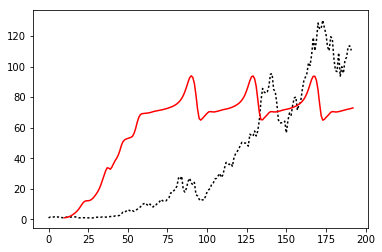

In [7]:
part_of_sequence = np.array([stock_prices[i] for i in range(LENGTH_PER_UNIT)])
predicted = [None for i in range(LENGTH_PER_UNIT)]

Z = X_train[:1, :, :]

for i in range(stock_prices.size - LENGTH_PER_UNIT + 1):
    y = model.predict(Z)
    Z = np.concatenate(
           (Z.reshape(LENGTH_PER_UNIT, DATA_DIMENSION)[1:], y),
           axis=0).reshape(1, LENGTH_PER_UNIT, DATA_DIMENSION)
    predicted.append(y.reshape(-1))

plt.figure()
plt.plot(stock_prices, linestyle='dotted', color='black')
plt.plot(predicted, color='red')
plt.show()